# [Quest] MainQuest 1

## 1. Transformer와 비교해 변경이 필요한 부분을 서술하였다.
- 제출 노트북 파일 첫부분에 텍스트 블럭으로 서술합니다. 아키텍쳐 상 변경사항을 블럭단위로 서술합니다.
- 코드블럭에 변경사항을 주석으로 표시합니다.

### 비교 및 아키텍쳐 상 변경사항
1. GPT-1은 encoder를 사용하지 않는다. (Decoder-only)
2. GPT-1의 decoder는 'Masked Multi Self Attention' - LN - 'Feed Forward' - LN - 출력 으로 이루어져있다.\
즉, 인코더와 디코더의 입력을 처리하는 encoder-decoder 레이어가 없다.
3. GPT-1은 주어진 단어들을 순차적으로 처리하는 AR 모델이므로, 이전 단어들만을 고려해서 다음 단어를 예측한다.\
= create_padding_mask()

**GPT-1 decoder 함수 구현**

In [1]:
import tensorflow as tf

In [9]:
# 스케일드 닷 프로덕트 어텐션 함수 (변경사항 X)
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [10]:
# 멀티 헤드 어텐션 함수 (변경사항 X)
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [11]:
# 패딩 마스킹 (변경사항 X)
def create_padding_mask(x):
    """
    주어진 시퀀스에 대해 패딩 마스크를 생성하는 함수
    - 패딩된 부분은 1로, 유효한 부분은 0으로 마스크
    """
    padding_mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return padding_mask[:, tf.newaxis, tf.newaxis, :]

In [65]:
# 룩 어헤드 마스킹 (변경사항 X) - AR모델 기반일 때 causal mask로 사용
def create_look_ahead_mask(x):
    """
    룩 어헤드 마스크와 패딩 마스크를 결합하는 함수.
    - 현재 단어 이후의 단어들을 마스크하고,
    - 패딩된 부분을 무시하는 마스크를 결합합니다.
    
    :param x: 입력 시퀀스
    :return: 결합된 마스크 (Causal + Padding Mask)
    """
    seq_len = tf.shape(x)[1]
    batch_size = tf.shape(x)[0]  # 배치 크기 구하기
    
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    look_ahead_mask = look_ahead_mask[tf.newaxis, tf.newaxis, :, :]
    
    #look_ahead_mask를 배치 크기에 맞게 확장: (batch_size, 1, seq_len, seq_len)
    look_ahead_mask = tf.tile(look_ahead_mask, [batch_size, 1, 1, 1])
    
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [13]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
        # inputs가 2D 텐서일 경우, 임베딩을 통해 3D 텐서로 변환
        if len(tf.shape(inputs)) == 2:  # (batch_size, seq_len)
            seq_len = tf.shape(inputs)[1]
            d_model = 512  # d_model은 여러분의 모델에 맞게 설정
            embedding_layer = tf.keras.layers.Embedding(input_dim=5000, output_dim=d_model)  # 예시로 5000 단어사전 사용
            inputs = embedding_layer(inputs)  # (batch_size, seq_len, d_model)

        # inputs의 시퀀스 길이에 맞춰 pos_encoding을 자르고
        seq_len = tf.shape(inputs)[1]
        pos_encoding = self.pos_encoding[:, :seq_len, :]
        
        # pos_encoding을 inputs의 batch_size에 맞게 브로드캐스트
        batch_size = tf.shape(inputs)[0]  # inputs의 배치 크기
        pos_encoding = tf.broadcast_to(pos_encoding, [batch_size, seq_len, tf.shape(inputs)[2]])

        # pos_encoding과 inputs을 더하기 전에 dtype을 맞추기 위해 cast 처리
        inputs = tf.cast(inputs, tf.float32)

        # inputs와 pos_encoding을 더하기
        return inputs + pos_encoding  # 여기서 pos_encoding은 이미 inputs에 맞게 브로드캐스트됨

- GPT-1은 encoder를 사용하지 않는다. = Decoder-only (변경사항 O)
- 파라미터 enc_outputs 삭제 (입력 시퀀스를 인코딩할 때 사용하는데, GPT-1는 decoder만 사용)
- 파라미터 padding_mask 삭제 (주로 Encoder-Decoder 구조에서 필요)\
    GPT-1는 AR모델 기반이므로 Causal mask 사용해서 padding 처리 (2.에서 구현)

- GPT-1의 decoder는 'Masked Multi Self Attention' - LN - 'Feed Forward' - LN - 출력 으로 이루어져있다.\
즉, 인코더와 디코더의 입력을 처리하는 encoder-decoder attention 레이어가 없다.

In [66]:
# 디코더 하나의 레이어 함수 (변경사항 O)
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다. (Transformer에서 인코더-디코더 어텐션 삭제)
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs") # 현재 입력 (이전 단어들의 임베딩)
  look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask") # 마스크

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 드롭 아웃
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    
  # 잔차 연결 + LayerNormalization
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + inputs)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 잔차 연결 + LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention)

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask],
      outputs=outputs,
      name=name)

In [67]:
# 디코더 (변경사항 O)
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  
  inputs = tf.keras.Input(shape=(None, d_model), name='inputs') # 현재 단어의 인덱스 
  look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask') # 마스크

  # Dropout
  outputs = tf.keras.layers.Dropout(rate=dropout)(inputs)

  # Decoder Layer 반복
  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, look_ahead_mask])

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask],
      outputs=outputs,
      name=name)

## 2. 모델의 입력 형태에 맞게 전처리를 수행하였다.
- Decoder 기반의 생성모델임을 감안하여 챗봇 데이터를 변형합니다.
- 이번 과제는 pretrain을 위한 데이터셋과 학습만 고려합니다.

### 텍스트 데이터 전처리 과정
1. 디코더 모델의 입력 데이터로 적합한 형태로 변경
2. 텍스트 시퀀스 토큰화
3. Causal Mask (AR 마스크)

**데이터 로드 및 공백, 특수문자 처리**

In [18]:
import re
import csv
import tensorflow_datasets as tfds

In [19]:
# 질문과 답변을 전처리하는 함수
def preprocess_sentence(text):
    """
    입력된 텍스트에서 공백과 특수문자를 제거하는 함수
    - 불필요한 공백 제거
    - 특수문자 및 숫자 제거
    """
    # 단어와 구두점(punctuation) 사이 공백
    text = re.sub(r"([?.!,])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    # 특수문자 및 숫자 제거
    text = re.sub(r'[^가-힣\s]', '', text)  # 한글, 공백만 남기고 제거
    # 불필요한 공백 제거
    text = re.sub(r'\s+', ' ', text).strip()  # 여러 공백을 하나로 치환 후 양쪽 공백 제거
    return text

In [20]:
# CSV 파일을 로드하고, 질문, 답변, 라벨을 전처리하는 함수
def load_conversations(file_path):
    inputs, outputs, labels = [], [], []
    
    # CSV 파일을 읽어서 각 줄을 처리
    with open(file_path, mode='r', encoding='utf-8', errors='ignore') as file:
        reader = csv.reader(file)
        next(reader)  # 헤더가 있을 경우 첫 줄을 건너뛰기
        
        for row in reader:
            if len(row) == 3:  # Q, A, label이 존재하는지 확인
                question, answer, label = row
                # 질문과 답변 전처리
                inputs.append(preprocess_sentence(question))
                outputs.append(preprocess_sentence(answer))
                labels.append(label)  # 라벨도 저장
    
    return inputs, outputs, labels

In [21]:
file_path = '../aiffel/transformer_chatbot/data/ChatbotData .csv'

In [22]:
questions, answers, lables = load_conversations(file_path)
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [23]:
print('전처리 후의 10번째 질문 샘플: {}'.format(questions[9]))
print('전처리 후의 10번째 답변 샘플: {}'.format(answers[9]))

전처리 후의 10번째 질문 샘플: 시간낭비인데 자꾸 보게됨
전처리 후의 10번째 답변 샘플: 시간을 정하고 해보세요


### 텍스트 시퀀스 토큰화

In [24]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [25]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8144]
END_TOKEN의 번호 : [8145]


In [26]:
VOCAB_SIZE = tokenizer.vocab_size + 2  # 시작/종료 토큰을 고려하여 +2
print(VOCAB_SIZE)

8146


In [27]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 10번째 질문 샘플: {}'.format(tokenizer.encode(questions[9])))
print('정수 인코딩 후의 10번째 답변 샘플: {}'.format(tokenizer.encode(answers[9])))

정수 인코딩 후의 10번째 질문 샘플: [772, 7594, 195, 79, 177, 362, 1251]
정수 인코딩 후의 10번째 답변 샘플: [343, 3965, 13, 29]


In [28]:
# 질문과 답변을 Subword 토큰화
def tokenize_and_add_tokens(questions, answers):
    tokenized_questions = []
    tokenized_answers = []
    
    for question, answer in zip(questions, answers):
        # [START]와 [END] 토큰 추가
        tokenized_question = [START_TOKEN[0]] + tokenizer.encode(question) + [END_TOKEN[0]]
        tokenized_answer = [START_TOKEN[0]] + tokenizer.encode(answer) + [END_TOKEN[0]]
        
        tokenized_questions.append(tokenized_question)
        tokenized_answers.append(tokenized_answer)
    
    return tokenized_questions, tokenized_answers

In [29]:
questions, answers = tokenize_and_add_tokens(questions, answers)

In [30]:
# 앞에 [START], 뒤에 [END] 토큰 결합 확인
print('10번째 질문 샘플: {}'.format(questions[9]))
print('10번째 질문 샘플: {}'.format(answers[9]))

10번째 질문 샘플: [8144, 772, 7594, 195, 79, 177, 362, 1251, 8145]
10번째 질문 샘플: [8144, 343, 3965, 13, 29, 8145]


## 3. 모델의 입력 블럭을 GPT 논문에 기반하여 수정하였다.
- 모델의 input이 정상적으로 구성되었는지 확인합니다.
- 데이터에 위치 정보를 추가하는 과정을 구현합니다.

### 디코더 모델에 입력 데이터로 적합한 형식으로 변환
- GPT-1 모델 입력 데이터 형식으로 변환

In [31]:
# 질문과 답변을 하나의 시퀀스로 결합하여 모델에 적합한 형식으로 변환
def prepare_gpt1_input(tokenized_questions, tokenized_answers):
    input_sequences = []
    target_sequences = []
    
    for question, answer in zip(tokenized_questions, tokenized_answers):
        # 입력: question + [END] + answer
        input_sequence = question + answer[1:]  # answer[1:]는 [START] 토큰 제외
        target_sequence = answer  # 모델은 answer의 시작 부분부터 예측
        
        input_sequences.append(input_sequence)
        target_sequences.append(target_sequence)
    
    return input_sequences, target_sequences

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [33]:
# 모델 학습에 사용할 입력 데이터 준비
input_sequences, target_sequences = prepare_gpt1_input(questions, answers)

적절한 max_len 분석

In [34]:
# Input sequences의 길이 계산
input_lengths = [len(seq) for seq in input_sequences]
max_input_len = max(input_lengths)
avg_input_len = sum(input_lengths) / len(input_lengths)

# Target sequences의 길이 계산
target_lengths = [len(seq) for seq in target_sequences]
max_target_len = max(target_lengths)
avg_target_len = sum(target_lengths) / len(target_lengths)

print("Input sequences의 가장 긴 길이:", max_input_len)
print("Input sequences의 평균 길이:", avg_input_len)

print("Target sequences의 가장 긴 길이:", max_target_len)
print("Target sequences의 평균 길이:", avg_target_len)

Input sequences의 가장 긴 길이: 38
Input sequences의 평균 길이: 12.925230482956948
Target sequences의 가장 긴 길이: 29
Target sequences의 평균 길이: 6.806140573458513


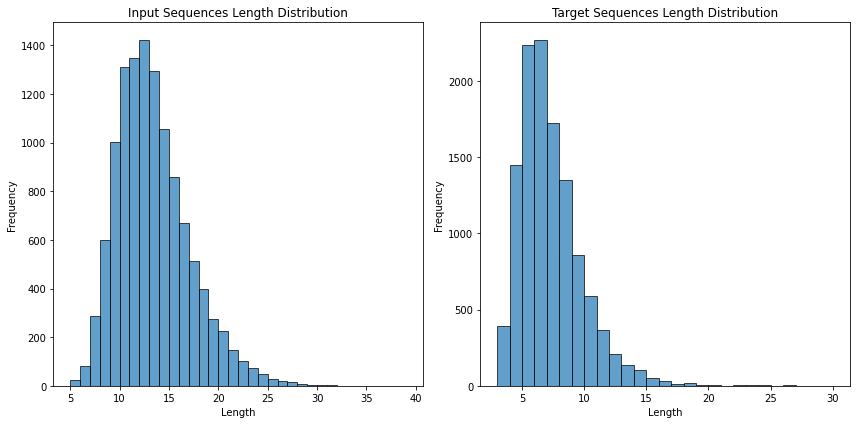

In [35]:
import matplotlib.pyplot as plt

# 각 시퀀스의 길이를 계산
input_lengths = [len(seq) for seq in input_sequences]
target_lengths = [len(seq) for seq in target_sequences]

# 히스토그램 그리기
plt.figure(figsize=(12, 6))

# Input sequences 히스토그램
plt.subplot(1, 2, 1)  # (행, 열, 위치)
plt.hist(input_lengths, bins=range(min(input_lengths), max(input_lengths) + 2), edgecolor='black', alpha=0.7)
plt.title('Input Sequences Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Target sequences 히스토그램
plt.subplot(1, 2, 2)  # (행, 열, 위치)
plt.hist(target_lengths, bins=range(min(target_lengths), max(target_lengths) + 2), edgecolor='black', alpha=0.7)
plt.title('Target Sequences Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

# 전체 히스토그램 표시
plt.tight_layout()
plt.show()

input_sequences, target_sequences의 합일 때 적절한 max_len의 값을 40으로 그대로 잡아도 괜찮을 것 같다.

In [36]:
MAX_SEQ_LENGTH = 40  # 시퀀스 최대 길이

In [37]:
# 입력과 출력 시퀀스에 대한 패딩 추가
inputs = pad_sequences(input_sequences, maxlen=MAX_SEQ_LENGTH, padding='post', truncating='post')
targets = pad_sequences(target_sequences, maxlen=MAX_SEQ_LENGTH, padding='post', truncating='post')

# 패딩된 시퀀스 출력
print("패딩된 입력 시퀀스 (10번째):", inputs[9])
print("패딩된 출력 시퀀스 (10번째):", targets[9])

패딩된 입력 시퀀스 (10번째): [8144  772 7594  195   79  177  362 1251 8145  343 3965   13   29 8145
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
패딩된 출력 시퀀스 (10번째): [8144  343 3965   13   29 8145    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


**변형 완료**

입력 시퀀스 : [START] inputs [END] target [END] [PAD] ...

출력 시퀀스 : [START] target [END] [PAD] ...

### Causal Mask (AR 마스크)
- 일전에 정의했던 `create_padding_mask()` 사용

In [80]:
inputs.shape

(11823, 40)

**교사 강요**

In [79]:
# tf.data.Dataset 생성
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))

# 데이터셋을 배치 단위로 묶고, look_ahead_mask를 추가
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 데이터를 적절히 매핑
def map_fn(inputs, target):
    # Look-ahead 마스크 생성
    look_ahead_mask = create_look_ahead_mask(inputs)
    padding_mask = create_padding_mask(inputs)
    
    # (inputs, look_ahead_mask) 형태로 반환
    return (inputs, look_ahead_mask), target  # 모델이 두 개의 입력을 받을 수 있도록

# 데이터셋에 map_fn을 적용
dataset = dataset.map(map_fn).cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

ValueError: in user code:

    /tmp/ipykernel_381/3777036633.py:11 map_fn  *
        look_ahead_mask = create_look_ahead_mask(inputs)
    /tmp/ipykernel_381/381776603.py:11 create_look_ahead_mask  *
        seq_len = tf.shape(x)[1]
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:1041 _slice_helper
        return strided_slice(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:1214 strided_slice
        op = gen_array_ops.strided_slice(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/gen_array_ops.py:10538 strided_slice
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:3561 _create_op_internal
        ret = Operation(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: slice index 1 of dimension 0 out of bounds. for '{{node strided_slice}} = StridedSlice[Index=DT_INT32, T=DT_INT32, begin_mask=0, ellipsis_mask=0, end_mask=0, new_axis_mask=0, shrink_axis_mask=1](Shape, strided_slice/stack, strided_slice/stack_1, strided_slice/stack_2)' with input shapes: [1], [1], [1], [1] and with computed input tensors: input[1] = <1>, input[2] = <2>, input[3] = <1>.


### 포지셔널 인코딩 (위치 정보)
- 일전에 정의했던 `PositionalEncoding()` 사용

## 4. GPT 모델을 정상적으로 구성하였다.(model.summary, model.fit 결과 캡쳐 첨부)
- 노드의 transformer 코드를 수정하여 GPT1 모델을 구성합니다.

In [68]:
def gpt_1(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="gpt_1"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  
  # 룩 어헤드 마스크 입력 정의
  look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")  # look_ahead_mask는 inputs 기반으로 생성
    
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))  # 차원 크기 (d_model)로 스케일링
  
  # 포지셔널 인코딩을 입력 임베딩에 추가
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)  # 포지셔널 인코딩 추가

  # Dropout
  embeddings = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더
  outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[embeddings, look_ahead_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(outputs)

  return tf.keras.Model(inputs=[inputs, look_ahead_mask], outputs=outputs, name=name)

**모델 생성**

In [69]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = gpt_1(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "gpt_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 512)    4170752     inputs[0][0]                     
__________________________________________________________________________________________________
tf.math.multiply (TFOpLambda)   (None, None, 512)    0           embedding[0][0]                  
__________________________________________________________________________________________________
positional_encoding (Positional (None, None, 512)    0           tf.math.multiply[0][0]           
______________________________________________________________________________________________

**손실 함수**

In [53]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

**커스텀 된 학습률**

In [54]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

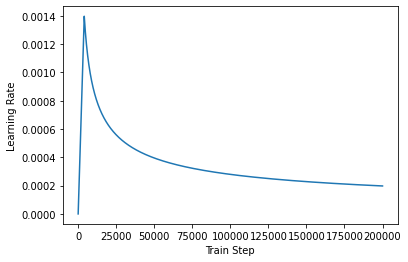

In [55]:
import matplotlib.pyplot as plt

sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

**모델 컴파일**

In [70]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [78]:
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:199 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer gpt_1 expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 40) dtype=int32>]


## 5. 입력에 따른 출력이 생성되었다.
- 출력 결과물의 수준에 상관없이 모델이 정상적으로 동작하는지 확인합니다.

In [ ]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [ ]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
sentence_generation('오늘 뭐할까?')